In [1]:
import deps

## 1. Abstractions for representing environments

Environmental models can be represented either through a GridMeshModel or a TriMeshModel, using a grid and a triangular based representation of the environment, respectively. Here we will document how to use the GridMeshModel representation. Several ways exist to define the environment, we will start with the simplest one, which is based on having an array of elevations where each entry to the array represents the elevation at a coordinate corresponding to the row and the column.

In [2]:
from pextant.mesh.abstractmesh import NpDataset
import numpy as np

In [3]:
xx,yy= np.mgrid[0:5,0:5]

In [4]:
basic_terrain = NpDataset(0.1*(xx**2+yy**2), resolution=1)
basic_terrain

array([[0. , 0.1, 0.4, 0.9, 1.6],
       [0.1, 0.2, 0.5, 1. , 1.7],
       [0.4, 0.5, 0.8, 1.3, 2. ],
       [0.9, 1. , 1.3, 1.8, 2.5],
       [1.6, 1.7, 2. , 2.5, 3.2]])

This dataset is wrapped around numpy so we can access can easily access entries:

In [5]:
basic_terrain[1,1]

0.2

Or access several entries, and even interpolate

In [6]:
basic_terrain.get_datapoint(np.array(([1,1],[1.5,1.5])))

array([0.2, 0.5])

### 1.1 GridMesh

If we want to anchor the mesh to a geographical location, we will use the class GridMesh, and supply the coordinate of the upper left point of the terrain. Its important that this representation is agnostic of what the dataset contains; so far this just represents an abstract dataset with resolution, rows and columns (doesnt have to be a terrain)

In [7]:
from pextant.EnvironmentalModel import GridMesh
from pextant.lib.geoshapely import GeoPoint, LAT_LONG

In [8]:
upper_left_corner = GeoPoint(LAT_LONG, 0, 0) # this will be the north-west corner of the dataset
basic_mesh = GridMesh(upper_left_corner, basic_terrain)

We can read out some basic properties of the mesh, and plot it

In [9]:
print(basic_mesh)

height: 5 
width: 5 
resolution: 1 
nw corner: POINT (166021.4430805406 0)


The upper left corner can be accessed, and returns our original anchoring point. The lower right corner is also accessible for convenience:

In [10]:
upper_left_corner, lower_right_corner = basic_mesh.nw_geo_point, basic_mesh.se_geo_point

We can also access the original terrain dataset through the dataset keyword

In [11]:
basic_mesh.dataset.y_size

5

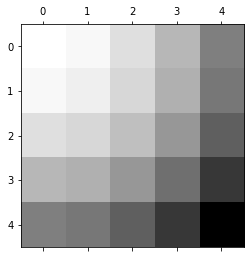

In [12]:
import matplotlib.pyplot as plt
plt.matshow(basic_mesh.dataset.data_container, cmap='gray_r')
plt.show()

GridMesh also stores the local coordinate system of the grid, which can then be converted back and forth to other representations. The two coordinate systems are called ROW_COL and COL_ROW, which allows to define a point given the row and the column.

In [13]:
point_in_mesh = GeoPoint(basic_mesh.ROW_COL, 1, 1)

### 1.2 GridMeshModel

This is when we transform a terrain into a representation that the path planner can use. This adds a large set of methods to terrain useful for its analysis. The easiest way to generate the model is to just derive it from the GridMesh we already have. To do so, we can load a smaller part of the dataset we have so far, say for example in a given envelope.

All the methods from GridMesh are still available in GridMeshModel

In [14]:
from pextant.lib.geoshapely import GeoEnvelope

In [15]:
model_envelope = GeoEnvelope(point_in_mesh, lower_right_corner)
terrain_model = basic_mesh.loadSubSection(model_envelope) 

If no envelope is passed as an argument, the entire dataset is processed. Be careful with this, as it might take up significant memory if a very large dataset is being used.

In [16]:
import matplotlib.patches as patches

Before we used dataset to access the underlying heightmap. For the model we will use the data property, which carries the raw representation of the data.

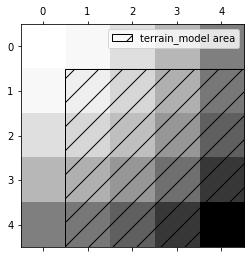

In [17]:
plt.matshow(basic_mesh.data, cmap='gray_r')
plt.gca().add_patch(patches.Rectangle(point_in_mesh.to(basic_mesh.ROW_COL)-np.array([0.5,0.5]),basic_mesh.y_size,basic_mesh.x_size, fill=False, hatch='/'))
plt.legend(["terrain_model area"])
plt.show()

#### 1.3 Model info
The model contains information on the slopes, and an obstacle map, which is currently set to terrain steeper than 35 degrees

In [18]:
terrain_model.slopes

array([[22.98976777, 26.56505118, 33.85451481, 37.29207574],
       [26.56505118, 29.4962085 , 35.79575991, 38.87665514],
       [33.85451481, 35.79575991, 40.31554221, 42.6746455 ],
       [37.29207574, 38.87665514, 42.6746455 , 44.71062246]])

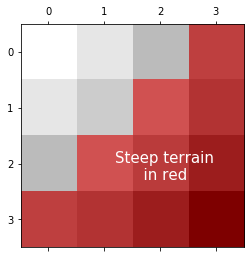

In [19]:
plt.matshow(terrain_model.dataset, cmap='gray_r')
plt.imshow(terrain_model.obstacle_mask(), alpha=0.5, cmap='bwr_r')
plt.text(1.2,2.3,"Steep terrain \n      in red", size=15, color="white")
plt.show()

The code below demonstrates a more advanced usage of GeoMesh

## 2. Importing DEMs

### 2.1 GeoTiff

SEXTANT comes with handy helper objects to help import GeoTiffs, which are the preferred datatype for Data Elevation Maps (DEM). This is done with a library called GDAL, the Geospatial Data Abstraction Library, and hence the class is called GDALMesh. The GDALMesh class inherits from GridMesh, meaning that we can play around with it in the exact same way we did with the earlier example.

In [20]:
from pextant.EnvironmentalModel import GDALMesh

We will use a 0.5 resolution DEM of NASA Ames Roverscape site

In [21]:
ames_gridmesh = GDALMesh('Ames.tif')

In [22]:
print(ames_gridmesh)

height: 237 
width: 161 
resolution: 0.5 
nw corner: POINT (582678.314647603 4141911.40834981)


Whats different in this representation from when we had a GridMesh with a numpy array, is that if we access the dataset we wont get an array. This is because the DEM is still encoded, and wont be decoded until loadSubSection has been called; this is done to limit memory used when larger DEMs (100s of MB or GB size) are being used.

Since we see its a small dataset, let's just load it fully:

In [23]:
ames_model = ames_gridmesh.loadSubSection()

We can display it, including the obstacles in red

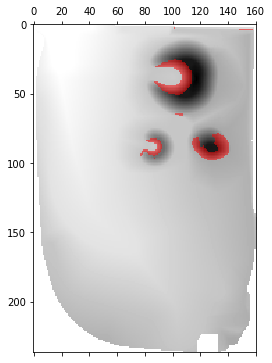

In [24]:
plt.matshow(ames_model.data, cmap='gray_r')
obstacle_transparent = np.ma.masked_array(np.ones_like(ames_model.data), ames_model.slopes<15)
plt.imshow(obstacle_transparent, alpha=0.5, cmap='bwr_r')
plt.show()

We notice that some of the areas are white; these represent masked locations, that are points with a no data value such as -9999.

Now that we are dealing with real data, let's also do a hillshade visualization in matplotlib:

In [25]:
from pextant.viz.utils import hillshade

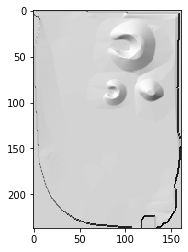

In [26]:
hillshade(ames_model, 5) #5 is used to exaggerate the effect of the hillshade
plt.show()

### 2.2 From text file

Legacy terrain for SEXTANT was stored in text files, and there is a simpler helper function that can load it as a GridMeshModel(so dont need to loadSubSection)

In [27]:
from pextant.EnvironmentalModel import load_legacy

LOLA(Lunar Orbiter Laser Altimeter) instrument recently generated a 2m DEM of the Lunar terrain. The data has been post processed into the format of the legacy code, and is displayed below as an example.

In [28]:
apollo14_mesh = load_legacy('Apollo14.txt')

In [29]:
apollo14_model = apollo14_mesh.loadSubSection()

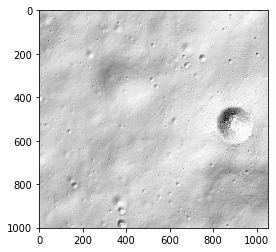

In [30]:
hillshade(apollo14_model, 1)
plt.show()

## 3. Other Representations: TriMesh

SEXTANT can also triangulate the terrain and represent it as a TriMesh. It triangulates the grid, and then uses an algorithm developped by Garland to decimate it and generate triangles in areas that need a larger density of triangles to accurately describe the terrain.

In [31]:
from pextant.mesh.triangularmesh import grid_to_tri

In [32]:
apollo14_tri = grid_to_tri(apollo14_model, accuracy=3)

In [33]:
tri = apollo14_tri.data

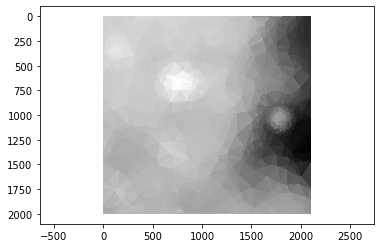

In [34]:
plt.gca().invert_yaxis()
plt.tripcolor(tri.vertices[:,0], tri.vertices[:,1], tri.faces, facecolors=tri.triangles_center[:,2], cmap='gray_r', alpha=1.)
plt.axis('equal')
plt.show()